# Sensitivity Analysis: metric for parameters

In order to systematically probe a parameter's sensitivity, its partial derivative wrt the distance is calculated, and its range at 2.5, 5, 10 and 25% (for example) of the final parameter are averaged to get a final metric

 ## First, let's generate the data, just having k1 as a parameter:

In [2]:
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

#Distance function
def euclidean_distance_multiple_trajectories(observed_trajectories, simulated_trajectories):
    num_trajectories = len(observed_trajectories)
    total_distance = 0.0

    for i in range(num_trajectories):
        observed_data = observed_trajectories[i]
        simulated_data = simulated_trajectories[i]

        # Calculate the Euclidean distance between observed and simulated data
        euclidean_distance = np.linalg.norm(observed_data - simulated_data)

        # Accumulate the distances
        total_distance += euclidean_distance

    # Average the distances over all trajectories
    average_distance = total_distance / num_trajectories

    return average_distance

In [2]:
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** k3 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

true_params = np.array([
    0, 0, 0  # first set of odes
])

def solve_ode(params, t):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    solution = odeint(model, initial_conditions, t, args=(params,))
    return solution

num_timesteps = 10  # Number of time steps for simulation
t = np.linspace(0, 100, num_timesteps)
true_data = solve_ode(true_params, t)

 ## Now, let's generate a sequence of ks that corresponds to 10% of the final parameter: since the true parameter is 0 (10^0), then we will sample from -1 to 1.

Text(0.5, 0, 'k1')

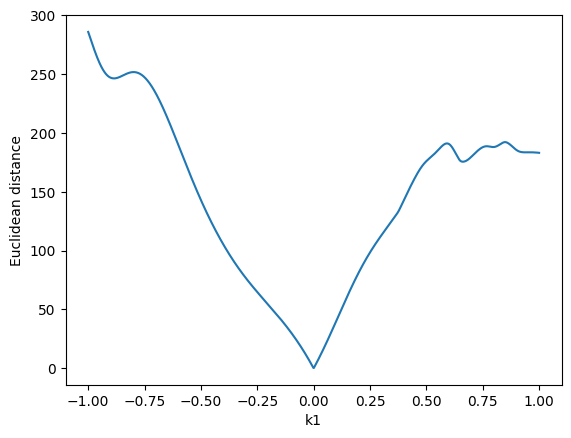

In [3]:
datapoints = 1000
k1_seq = np.linspace(-1, 1, datapoints) #All ks behave the same
k2_seq = np.linspace(-1, 1, datapoints)
k3_seq = np.linspace(-1, 1, datapoints)
#Try for k1
D_k1 = []
k1_collect = []
for i in range(np.size(k1_seq)):
    k1params = np.array([k1_seq[i], 0, 0])
    k1_collect.append(k1params)
    data_k1 = solve_ode(k1params, t)
    dist = euclidean_distance_multiple_trajectories(true_data, data_k1)
    D_k1.append(dist)

plt.plot(k1_seq, D_k1)
plt.ylabel("Euclidean distance")
plt.xlabel("k1")

## We now calculate the metric by obtaining the derivative of the distance wrt the parameter

0.6319011384370535

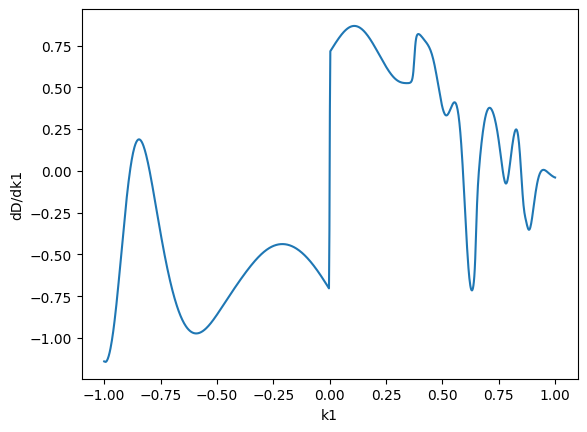

In [4]:
# datapoints = 1000 # Defined above, how many steps in parameter space we have taken
step_size = np.array([4,5,6]) #Steps to take right and left, the higher the number, the closer to the true value

#To get indices we sample:
indices_array = []
for i in step_size:
    indices_array.append(np.array([datapoints//i, -datapoints//i])) #How many steps do we record?

#To get index of the minimum D:
def min_val_ind(arr_y):
    target_value = min(arr_y)
    indices = np.where(arr_y == target_value)[0]
    
    if indices.size > 0:
        return indices
    else:
        return f"The value {target_value} is not present in the array."

#To get the ks that correspond to the indices we sample:
lowestD_k = k1_seq[min_val_ind(D_k1)]
ind_min_k = int(min_val_ind(D_k1))
array_k_eval = []
for i in indices_array:
    upperk = ind_min_k + i[0]
    lowerk = ind_min_k - i[0]
    array_k_eval.append(np.array([k1_seq[int(upperk)], k1_seq[int(lowerk)]]))
#Same for Distance
array_D_eval = []
for i in indices_array:
    upperk = ind_min_k + i[0]
    lowerk = ind_min_k - i[0]
    array_D_eval.append(np.array([D_k1[int(upperk)], D_k1[int(lowerk)]]))

#We collate everything in an array, calculate the derivative, which we can then plot
k1_array = np.array([k1_seq, D_k1])
grad = np.gradient(k1_array)
plt.plot(k1_seq, grad[1][1]) #Could also use np.diff, same result
plt.ylabel("dD/dk1")
plt.xlabel("k1")

#Retrieve the derivative at key points
dD_array = []
for i in indices_array:
    upperk = ind_min_k + i[0]
    lowerk = ind_min_k - i[0]
    dD_array.append(np.array([grad[1][1][int(upperk)], grad[1][1][int(lowerk)]]))

#calculate metric as the average of all points
def calc_sens_metric(dD_array):
    metric = []
    for arr in dD_array:
        metric.append((np.abs(arr[0]) + np.abs(arr[1])) /2)
    result = np.sum(metric) / len(dD_array)
    return np.abs(result)

calc_sens_metric(dD_array=dD_array)


In [5]:
dD_array

[array([ 0.38397946, -0.86356376]),
 array([ 0.81529014, -0.66169943]),
 array([ 0.525598  , -0.54127604])]

In [6]:
indices_array

[array([ 250, -250]), array([ 200, -200]), array([ 166, -167])]

In [7]:
array_k_eval

[array([ 0.4994995, -0.5015015]),
 array([ 0.3993994, -0.4014014]),
 array([ 0.33133133, -0.33333333])]

# Now do generic for any parameter (of the oscillatory system and for params centered at 0 (k, b))

In [14]:
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, a1, b1, n1, gamma1, k2, a2, b2, n2, gamma2, k3, a3, b3, n3, gamma3 = params

    dm1dt = -m1 + (10 ** a1 / (1 + (10 ** k1 * p2) ** n1)) + 10 ** gamma1
    dp1dt = -10 ** b1 * (p1 - m1)

    dm2dt = -m2 + (10 ** a2 / (1 + (10 ** k2 * p3) ** n2)) + 10 ** gamma2
    dp2dt = -10 ** b2 * (p2 - m2)

    dm3dt = -m3 + (10 ** a3 / (1 + (10 ** k3 * p1) ** n3)) + 10 ** gamma3
    dp3dt = -10 ** b3 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

true_params = np.array([
    0, 3, 0, 2, 0,  # first set of odes
    0, 3, 0, 2, 0, # second set of odes
    0, 3, 0, 2, 0  # third set of odes
])

def solve_ode(params, t):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    solution = odeint(model, initial_conditions, t, args=(params,))
    return solution

num_timesteps = 10  # Number of time steps for simulation
t = np.linspace(0, 100, num_timesteps)
true_data = solve_ode(true_params, t)

#To get index of the minimum D:
def min_val_ind(arr_y):
    target_value = min(arr_y)
    indices = np.where(arr_y == target_value)[0]
    
    if indices.size > 0:
        return indices

#The only thing we need to change is where the parameter is in param space! And distance function if we want!

def plots_sensitivity():
    datapoints = 1000 # How many steps in parameter space we have taken
    p_seq = np.linspace(-1, 1, datapoints) #All ks behave the same
    D_p = []
    p_collect = []
    for i in range(np.size(p_seq)):
        ########################################
        p_params = np.array([p_seq[i], 3, 0, 2, 0, 
                             0, 3, 0, 2, 0, 
                             0, 3, 0, 2, 0]) #Need to change this! In this case k1
        ########################################
        p_collect.append(p_params)
        data_p = solve_ode(p_params, t)
        dist = euclidean_distance_multiple_trajectories(true_data, data_p) #Can also change the distance function
        D_p.append(dist)

    step_size = np.array([10,100,500]) #Steps to take right and left, the higher the number, the closer to the true value

    #To get indices we sample:
    indices_array = []
    for i in step_size:
        indices_array.append(np.array([datapoints//i, -datapoints//i])) #How many steps do we record?

    #To get the ks that correspond to the indices we sample, and create useful arrays:
    min_ind = int(min_val_ind(D_p))
    global lowestD_p
    lowestD_p = p_seq[min_ind]
    global lowestD
    lowestD = D_p[min_ind]
    p_array = np.array([p_seq, D_p])
    grad = np.gradient(p_array) #Could also do np.diff, same result
    array_p_eval = []
    array_D_eval = []
    dD_array = []
    for i in indices_array:
        upperp = min_ind + i[0]
        lowerp = min_ind - i[0]
        array_p_eval.append(np.array([p_seq[int(upperp)], p_seq[int(lowerp)]])) #Save parameters
        array_D_eval.append(np.array([D_p[int(upperp)], D_p[int(lowerp)]])) #Same for distance
        dD_array.append(np.array([grad[1][1][int(upperp)], grad[1][1][int(lowerp)]])) #Same for derivative

    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    axs = axs.flatten()
    axs[0].plot(p_seq, D_p)
    axs[0].set_ylabel("Euclidean distance")
    axs[0].set_xlabel("p")
    axs[1].plot(p_seq, grad[1][1])
    axs[1].set_ylabel("dD/dp")
    axs[1].set_xlabel("p")

    return array_p_eval, array_D_eval #It returns where it is being evaluated!

def calc_sens_metric(array_p_eval, array_D_eval): #Try with log10
    p_raw = []
    D_raw = []
    for i in array_p_eval:  # Get raw arrays for metric calculation
        p_raw.append(i[0])
        p_raw.append(i[1])
    for i in array_D_eval:  # Get raw arrays for metric calculation
        D_raw.append(i[0])
        D_raw.append(i[1])
    deltaD = []
    deltap = []
    for p in p_raw:
        deltap.append(np.abs(p) - np.abs(lowestD_p))
    for D in D_raw:
        deltaD.append(np.abs(D) - np.abs(lowestD))
    metric = []
    for i in range(len(deltaD)):
        metric.append(np.abs(deltaD[i]) / np.abs(deltap[i]))
    result_sense = np.log(np.mean(metric))
    return result_sense

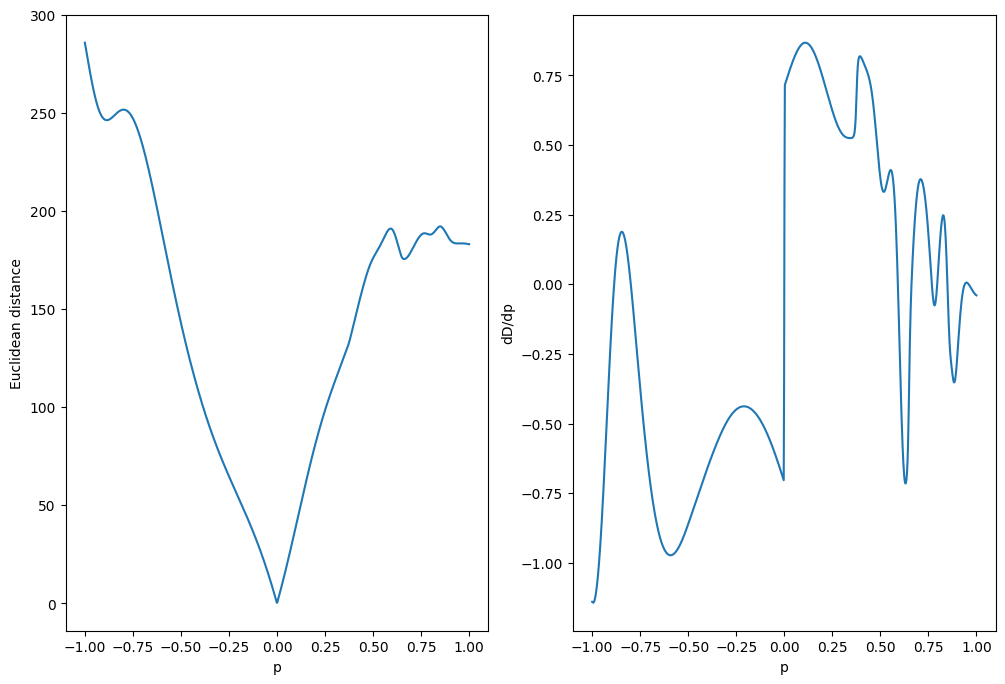

In [15]:
array_p_eval_k, array_D_eval_k = plots_sensitivity()

In [16]:
calc_sens_metric(array_p_eval_k, array_D_eval_k)

5.85392081480568

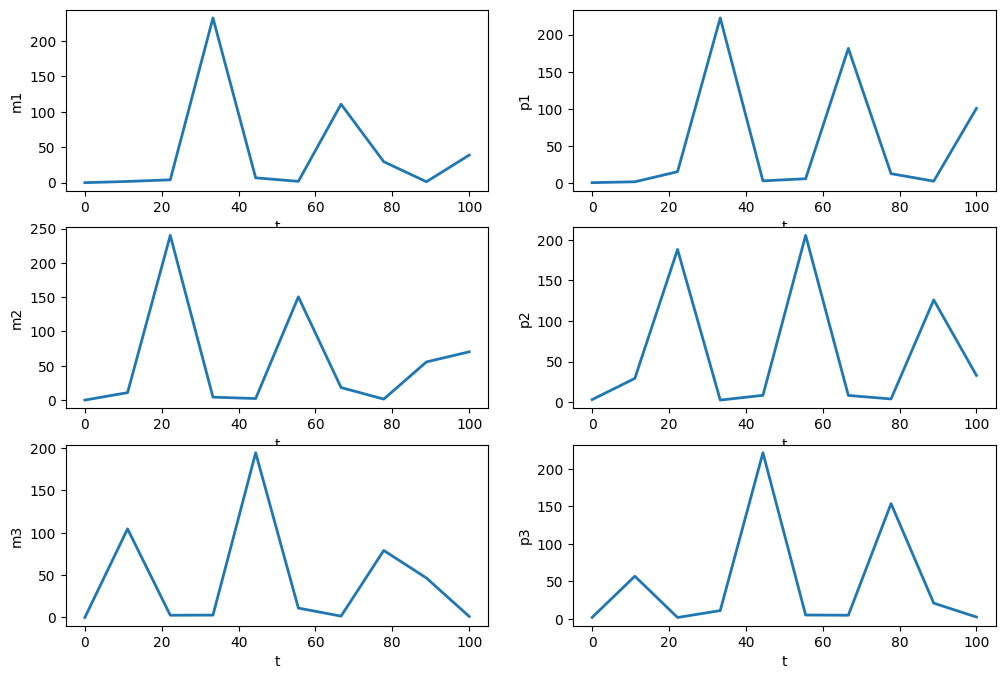

In [17]:
#Plot real trajectories for security
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
axs = axs.flatten()

variable_labels = ['m1', 'p1', 'm2', 'p2', 'm3', 'p3']
for i in range(6):
    axs[i].plot(t, true_data[:, i], label='True Data', linewidth=2)
    axs[i].set_xlabel('t')
    axs[i].set_ylabel(variable_labels[i])

## try with beta1

In [19]:
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, a1, b1, n1, gamma1, k2, a2, b2, n2, gamma2, k3, a3, b3, n3, gamma3 = params

    dm1dt = -m1 + (10 ** a1 / (1 + (10 ** k1 * p2) ** n1)) + 10 ** gamma1
    dp1dt = -10 ** b1 * (p1 - m1)

    dm2dt = -m2 + (10 ** a2 / (1 + (10 ** k2 * p3) ** n2)) + 10 ** gamma2
    dp2dt = -10 ** b2 * (p2 - m2)

    dm3dt = -m3 + (10 ** a3 / (1 + (10 ** k3 * p1) ** n3)) + 10 ** gamma3
    dp3dt = -10 ** b3 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

true_params = np.array([
    0, 3, 0, 2, 0,  # first set of odes
    0, 3, 0, 2, 0, # second set of odes
    0, 3, 0, 2, 0  # third set of odes
])

def solve_ode(params, t):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    solution = odeint(model, initial_conditions, t, args=(params,))
    return solution

num_timesteps = 10  # Number of time steps for simulation
t = np.linspace(0, 100, num_timesteps)
true_data = solve_ode(true_params, t)

#To get index of the minimum D:
def min_val_ind(arr_y):
    target_value = min(arr_y)
    indices = np.where(arr_y == target_value)[0]
    
    if indices.size > 0:
        return indices

#The only thing we need to change is where the parameter is in param space! And distance function if we want!

def plots_sensitivity():
    datapoints = 1000 # How many steps in parameter space we have taken
    p_seq = np.linspace(-1, 1, datapoints) #All ks behave the same
    D_p = []
    p_collect = []
    for i in range(np.size(p_seq)):
        ########################################
        p_params = np.array([0, 3, p_seq[i], 2, 0, 
                             0, 3, 0, 2, 0, 
                             0, 3, 0, 2, 0]) #Need to change this! In this case k1
        ########################################
        p_collect.append(p_params)
        data_p = solve_ode(p_params, t)
        dist = euclidean_distance_multiple_trajectories(true_data, data_p) #Can also change the distance function
        D_p.append(dist)

    step_size = np.array([10,100,500]) #Steps to take right and left, the higher the number, the closer to the true value

    #To get indices we sample:
    indices_array = []
    for i in step_size:
        indices_array.append(np.array([datapoints//i, -datapoints//i])) #How many steps do we record?

    #To get the ks that correspond to the indices we sample, and create useful arrays:
    min_ind = int(min_val_ind(D_p))
    global lowestD_p
    lowestD_p = p_seq[min_ind]
    global lowestD
    lowestD = D_p[min_ind]
    p_array = np.array([p_seq, D_p])
    grad = np.gradient(p_array) #Could also do np.diff, same result
    array_p_eval = []
    array_D_eval = []
    dD_array = []
    for i in indices_array:
        upperp = min_ind + i[0]
        lowerp = min_ind - i[0]
        array_p_eval.append(np.array([p_seq[int(upperp)], p_seq[int(lowerp)]])) #Save parameters
        array_D_eval.append(np.array([D_p[int(upperp)], D_p[int(lowerp)]])) #Same for distance
        dD_array.append(np.array([grad[1][1][int(upperp)], grad[1][1][int(lowerp)]])) #Same for derivative

    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    axs = axs.flatten()
    axs[0].plot(p_seq, D_p)
    axs[0].set_ylabel("Euclidean distance")
    axs[0].set_xlabel("p")
    axs[1].plot(p_seq, grad[1][1])
    axs[1].set_ylabel("dD/dp")
    axs[1].set_xlabel("p")

    return array_p_eval, array_D_eval #It returns where it is being evaluated!

def calc_sens_metric(array_p_eval, array_D_eval):
    p_raw = []
    D_raw = []
    for i in array_p_eval:  # Get raw arrays for metric calculation
        p_raw.append(i[0])
        p_raw.append(i[1])
    for i in array_D_eval:  # Get raw arrays for metric calculation
        D_raw.append(i[0])
        D_raw.append(i[1])
    deltaD = []
    deltap = []
    for p in p_raw:
        deltap.append(np.abs(p) - np.abs(lowestD_p))
    for D in D_raw:
        deltaD.append(np.abs(D) - np.abs(lowestD))
    metric = []
    for i in range(len(deltaD)):
        metric.append(np.abs(deltaD[i]) / np.abs(deltap[i]))
    result_sense = np.log(np.mean(metric))
    return result_sense

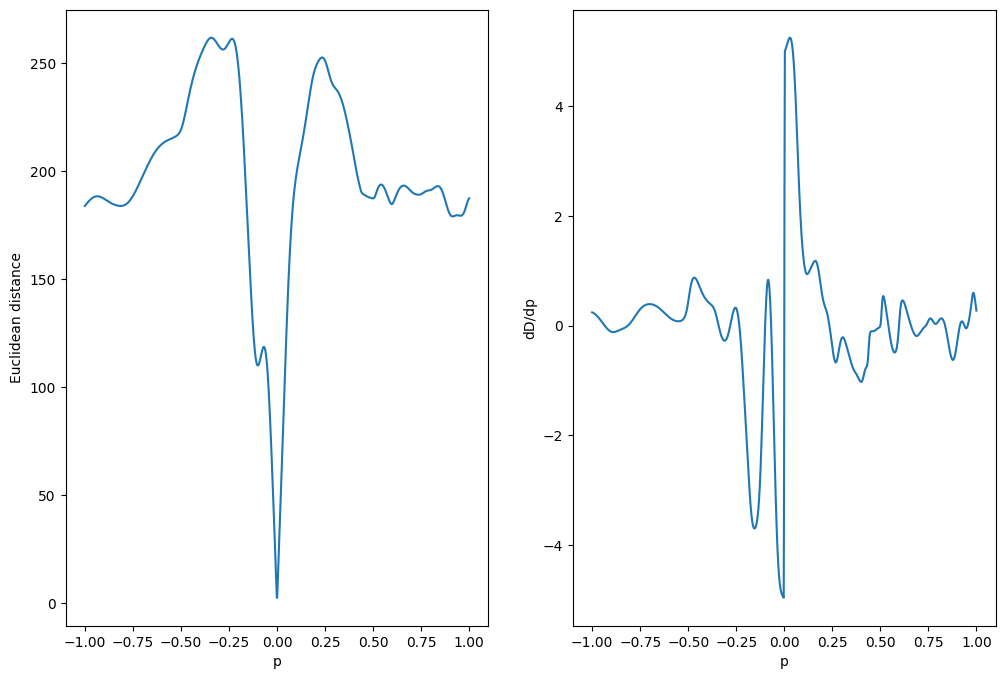

In [20]:
array_p_eval_b, array_D_eval_b = plots_sensitivity()

In [5]:
array_D_eval

[array([247.62109079, 248.23116338]),
 array([48.17707088, 51.47428656]),
 array([ 7.48609577, 12.40910113])]

In [26]:
calc_sens_metric(array_p_eval_b, array_D_eval_b)

7.635396432724096

In [31]:
def calc_sens_metriclog10(array_p_eval, array_D_eval):
    p_raw = []
    D_raw = []
    for i in array_p_eval:  # Get raw arrays for metric calculation
        p_raw.append(i[0])
        p_raw.append(i[1])
    for i in array_D_eval:  # Get raw arrays for metric calculation
        D_raw.append(i[0])
        D_raw.append(i[1])
    deltaD = []
    deltap = []
    for p in p_raw:
        deltap.append(np.abs(p) - np.abs(lowestD_p))
    for D in D_raw:
        deltaD.append(np.abs(D) - np.abs(lowestD))
    metric = []
    for i in range(len(deltaD)):
        metric.append(np.abs(deltaD[i]) / np.abs(deltap[i]))
    result_sense = np.log10(np.mean(metric))
    return result_sense

In [30]:
calc_sens_metriclog10(array_p_eval_b, array_D_eval_b)

3.316010537875848

In [29]:
calc_sens_metriclog10(array_p_eval_k, array_D_eval_k)

2.528857762665511

In [23]:
#Another alternative, log10
def calc_sens_metriclog10(array_p_eval, array_D_eval):
    p_raw = []
    D_raw = []
    for i in array_p_eval:  # Get raw arrays for metric calculation
        p_raw.append(i[0])
        p_raw.append(i[1])
    for i in array_D_eval:  # Get raw arrays for metric calculation
        D_raw.append(i[0])
        D_raw.append(i[1])
    deltaD = []
    deltap = []
    for p in p_raw:
        deltap.append(np.abs(p) - np.abs(lowestD_p))
    for D in D_raw:
        deltaD.append(np.abs(D) - np.abs(lowestD))
    metric = []
    for i in range(len(deltaD)):
        metric.append(np.abs(deltaD[i]) / np.abs(deltap[i]))
    result_sense = np.log10(np.mean(metric))
    return result_sense

In [24]:
calc_sens_metriclog10(array_p_eval_b, array_D_eval_b)

3.316010537875848

In [25]:
calc_sens_metriclog10(array_p_eval_k, array_D_eval_k)

2.528857762665511

## Try gamma!

In [39]:
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, a1, b1, n1, gamma1, k2, a2, b2, n2, gamma2, k3, a3, b3, n3, gamma3 = params

    dm1dt = -m1 + (10 ** a1 / (1 + (10 ** k1 * p2) ** n1)) + 10 ** gamma1
    dp1dt = -10 ** b1 * (p1 - m1)

    dm2dt = -m2 + (10 ** a2 / (1 + (10 ** k2 * p3) ** n2)) + 10 ** gamma2
    dp2dt = -10 ** b2 * (p2 - m2)

    dm3dt = -m3 + (10 ** a3 / (1 + (10 ** k3 * p1) ** n3)) + 10 ** gamma3
    dp3dt = -10 ** b3 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

true_params = np.array([
    0, 3, 0, 2, 0,  # first set of odes
    0, 3, 0, 2, 0, # second set of odes
    0, 3, 0, 2, 0  # third set of odes
])

def solve_ode(params, t):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    solution = odeint(model, initial_conditions, t, args=(params,))
    return solution

num_timesteps = 10  # Number of time steps for simulation
t = np.linspace(0, 100, num_timesteps)
true_data = solve_ode(true_params, t)

#To get index of the minimum D:
def min_val_ind(arr_y):
    target_value = min(arr_y)
    indices = np.where(arr_y == target_value)[0]
    
    if indices.size > 0:
        return indices

#The only thing we need to change is where the parameter is in param space! And distance function if we want!

def plots_sensitivity():
    datapoints = 1000 # How many steps in parameter space we have taken
    p_seq = np.linspace(-1, 1, datapoints) #All ks behave the same
    D_p = []
    p_collect = []
    for i in range(np.size(p_seq)):
        ########################################
        p_params = np.array([0, 3, 0, 2, p_seq[i], 
                             0, 3, 0, 2, 0, 
                             0, 3, 0, 2, 0]) #Need to change this! In this case k1
        ########################################
        p_collect.append(p_params)
        data_p = solve_ode(p_params, t)
        dist = euclidean_distance_multiple_trajectories(true_data, data_p) #Can also change the distance function
        D_p.append(dist)

    step_size = np.array([10,100,500]) #Steps to take right and left, the higher the number, the closer to the true value

    #To get indices we sample:
    indices_array = []
    for i in step_size:
        indices_array.append(np.array([datapoints//i, -datapoints//i])) #How many steps do we record?

    #To get the ks that correspond to the indices we sample, and create useful arrays:
    min_ind = int(min_val_ind(D_p))
    global lowestD_p
    lowestD_p = p_seq[min_ind]
    global lowestD
    lowestD = D_p[min_ind]
    p_array = np.array([p_seq, D_p])
    grad = np.gradient(p_array) #Could also do np.diff, same result
    array_p_eval = []
    array_D_eval = []
    dD_array = []
    for i in indices_array:
        upperp = min_ind + i[0]
        lowerp = min_ind - i[0]
        array_p_eval.append(np.array([p_seq[int(upperp)], p_seq[int(lowerp)]])) #Save parameters
        array_D_eval.append(np.array([D_p[int(upperp)], D_p[int(lowerp)]])) #Same for distance
        dD_array.append(np.array([grad[1][1][int(upperp)], grad[1][1][int(lowerp)]])) #Same for derivative

    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    axs = axs.flatten()
    axs[0].plot(p_seq, D_p)
    axs[0].set_ylabel("Euclidean distance")
    axs[0].set_xlabel("p")
    axs[1].plot(p_seq, grad[1][1])
    axs[1].set_ylabel("dD/dp")
    axs[1].set_xlabel("p")

    return array_p_eval, array_D_eval #It returns where it is being evaluated!

def calc_sens_metric(array_p_eval, array_D_eval):
    p_raw = []
    D_raw = []
    for i in array_p_eval:  # Get raw arrays for metric calculation
        p_raw.append(i[0])
        p_raw.append(i[1])
    for i in array_D_eval:  # Get raw arrays for metric calculation
        D_raw.append(i[0])
        D_raw.append(i[1])
    deltaD = []
    deltap = []
    for p in p_raw:
        deltap.append(np.abs(p) - np.abs(lowestD_p))
    for D in D_raw:
        deltaD.append(np.abs(D) - np.abs(lowestD))
    metric = []
    for i in range(len(deltaD)):
        metric.append(np.abs(deltaD[i]) / np.abs(deltap[i]))
    result_sense = np.log(np.mean(metric))
    return result_sense

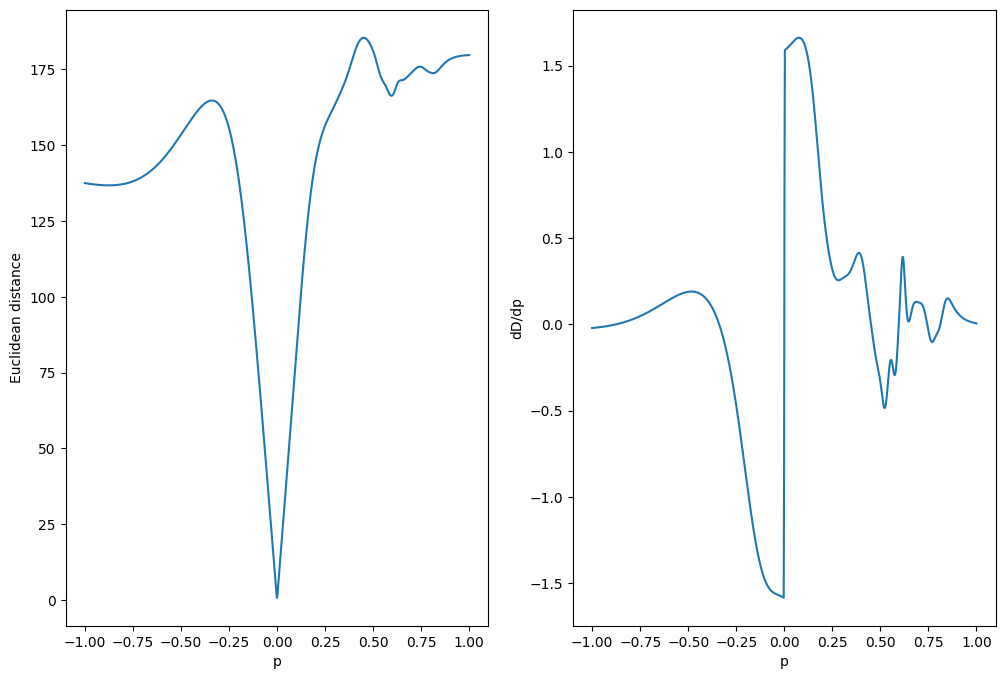

In [40]:
array_p_eval, array_D_eval = plots_sensitivity()

In [41]:
calc_sens_metric(array_p_eval, array_D_eval)

6.639547131611053

# Try to do this with parameters that are not 0 (alpha, n)!

In [55]:
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, a1, b1, n1, gamma1, k2, a2, b2, n2, gamma2, k3, a3, b3, n3, gamma3 = params

    dm1dt = -m1 + (10 ** a1 / (1 + (10 ** k1 * p2) ** n1)) + 10 ** gamma1
    dp1dt = -10 ** b1 * (p1 - m1)

    dm2dt = -m2 + (10 ** a2 / (1 + (10 ** k2 * p3) ** n2)) + 10 ** gamma2
    dp2dt = -10 ** b2 * (p2 - m2)

    dm3dt = -m3 + (10 ** a3 / (1 + (10 ** k3 * p1) ** n3)) + 10 ** gamma3
    dp3dt = -10 ** b3 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

true_params = np.array([
    0, 3, 0, 2, 0,  # first set of odes
    0, 3, 0, 2, 0, # second set of odes
    0, 3, 0, 2, 0  # third set of odes
])

def solve_ode(params, t):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    solution = odeint(model, initial_conditions, t, args=(params,))
    return solution

num_timesteps = 10  # Number of time steps for simulation
t = np.linspace(0, 100, num_timesteps)
true_data = solve_ode(true_params, t)

#To get index of the minimum D:
def min_val_ind(arr_y):
    target_value = min(arr_y)
    indices = np.where(arr_y == target_value)[0]
    
    if indices.size > 0:
        return indices

#The only thing we need to change is where the parameter is in param space! And distance function if we want!

def plots_sensitivity():
    datapoints = 1000 # How many steps in parameter space we have taken
    p_seq = np.linspace(2.95, 3.05, datapoints) #Since alpha is 10**3, we take 10% range, which is 900-1100, we get the same as if we took 2-4!
    D_p = []
    p_collect = []
    for i in range(np.size(p_seq)):
        ########################################
        p_params = np.array([0, 3, 0, 2, 0, # Now its alpha1!
                             0, p_seq[i], 0, 2, 0, 
                             0, 3, 0, 2, 0]) #Need to change this! In this case k1
        ########################################
        p_collect.append(p_params)
        data_p = solve_ode(p_params, t)
        dist = euclidean_distance_multiple_trajectories(true_data, data_p) #Can also change the distance function
        D_p.append(dist)

    step_size = np.array([10,100,500]) #Steps to take right and left, the higher the number, the closer to the true value, we take 0.1%, 1%, 5%

    #To get indices we sample:
    indices_array = []
    for i in step_size:
        indices_array.append(np.array([datapoints//i, -datapoints//i])) #How many steps do we record?

    #To get the ks that correspond to the indices we sample, and create useful arrays:
    min_ind = int(min_val_ind(D_p))
    global lowestD_p
    lowestD_p = p_seq[min_ind]
    global lowestD
    lowestD = D_p[min_ind]
    p_array = np.array([p_seq, D_p])
    grad = np.gradient(p_array) #Could also do np.diff, same result
    array_p_eval = []
    array_D_eval = []
    dD_array = []
    for i in indices_array:
        upperp = min_ind + i[0]
        lowerp = min_ind - i[0]
        array_p_eval.append(np.array([p_seq[int(upperp)], p_seq[int(lowerp)]])) #Save parameters
        array_D_eval.append(np.array([D_p[int(upperp)], D_p[int(lowerp)]])) #Same for distance
        dD_array.append(np.array([grad[1][1][int(upperp)], grad[1][1][int(lowerp)]])) #Same for derivative

    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    axs = axs.flatten()
    axs[0].plot(p_seq, D_p)
    axs[0].set_ylabel("Euclidean distance")
    axs[0].set_xlabel("p")
    axs[1].plot(p_seq, grad[1][1])
    axs[1].set_ylabel("dD/dp")
    axs[1].set_xlabel("p")

    return array_p_eval, array_D_eval #It returns where it is being evaluated!

def calc_sens_metric(array_p_eval, array_D_eval):
    p_raw = []
    D_raw = []
    for i in array_p_eval:  # Get raw arrays for metric calculation
        p_raw.append(i[0])
        p_raw.append(i[1])
    for i in array_D_eval:  # Get raw arrays for metric calculation
        D_raw.append(i[0])
        D_raw.append(i[1])
    deltaD = []
    deltap = []
    for p in p_raw:
        deltap.append(np.abs(p) - np.abs(lowestD_p))
    for D in D_raw:
        deltaD.append(np.abs(D) - np.abs(lowestD))
    metric = []
    for i in range(len(deltaD)):
        metric.append(np.abs(deltaD[i]) / np.abs(deltap[i]))
    result_sense = np.log(np.mean(metric))
    return result_sense

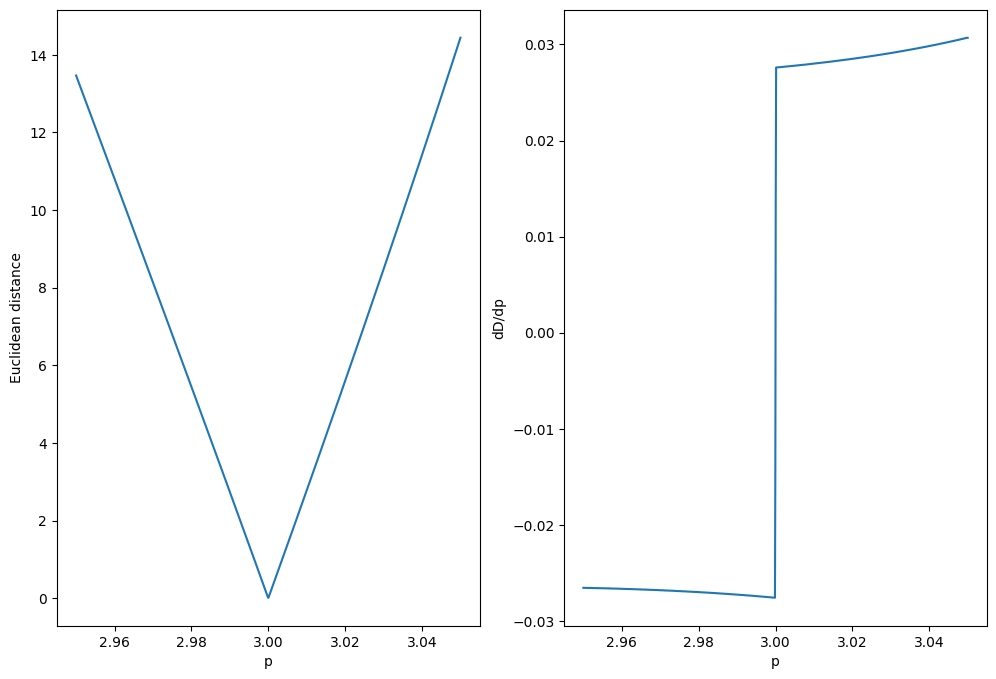

In [56]:
array_p_eval, array_D_eval = plots_sensitivity()

In [57]:
calc_sens_metric(array_p_eval, array_D_eval)

5.512110031991614

Different gammas, alphas, betas and ks behave very similarly.

Now the last one, n

In [64]:
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, a1, b1, n1, gamma1, k2, a2, b2, n2, gamma2, k3, a3, b3, n3, gamma3 = params

    dm1dt = -m1 + (10 ** a1 / (1 + (10 ** k1 * p2) ** n1)) + 10 ** gamma1
    dp1dt = -10 ** b1 * (p1 - m1)

    dm2dt = -m2 + (10 ** a2 / (1 + (10 ** k2 * p3) ** n2)) + 10 ** gamma2
    dp2dt = -10 ** b2 * (p2 - m2)

    dm3dt = -m3 + (10 ** a3 / (1 + (10 ** k3 * p1) ** n3)) + 10 ** gamma3
    dp3dt = -10 ** b3 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

true_params = np.array([
    0, 3, 0, 2, 0,  # first set of odes
    0, 3, 0, 2, 0, # second set of odes
    0, 3, 0, 2, 0  # third set of odes
])

def solve_ode(params, t):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    solution = odeint(model, initial_conditions, t, args=(params,))
    return solution

num_timesteps = 10  # Number of time steps for simulation
t = np.linspace(0, 100, num_timesteps)
true_data = solve_ode(true_params, t)

#To get index of the minimum D:
def min_val_ind(arr_y):
    target_value = min(arr_y)
    indices = np.where(arr_y == target_value)[0]
    
    if indices.size > 0:
        return indices

#The only thing we need to change is where the parameter is in param space! And distance function if we want!

def plots_sensitivity():
    datapoints = 1000 # How many steps in parameter space we have taken
    p_seq = np.linspace(1.95, 2.05, datapoints) #Since n is 10**2, we take 10% range, which is 90-110, we get the same as if we took 1.5-2.5!
    D_p = []
    p_collect = []
    for i in range(np.size(p_seq)):
        ########################################
        p_params = np.array([0, 3, 0, p_seq[i], 0, # Now its n1!
                             0, 3, 0, 2, 0, 
                             0, 3, 0, 2, 0]) #Need to change this! In this case k1
        ########################################
        p_collect.append(p_params)
        data_p = solve_ode(p_params, t)
        dist = euclidean_distance_multiple_trajectories(true_data, data_p) #Can also change the distance function
        D_p.append(dist)

    step_size = np.array([10,100,500]) #Steps to take right and left, the higher the number, the closer to the true value, we take 0.1%, 1%, 5%

    #To get indices we sample:
    indices_array = []
    for i in step_size:
        indices_array.append(np.array([datapoints//i, -datapoints//i])) #How many steps do we record?

    #To get the ks that correspond to the indices we sample, and create useful arrays:
    min_ind = int(min_val_ind(D_p))
    global lowestD_p
    lowestD_p = p_seq[min_ind]
    global lowestD
    lowestD = D_p[min_ind]
    p_array = np.array([p_seq, D_p])
    grad = np.gradient(p_array) #Could also do np.diff, same result
    array_p_eval = []
    array_D_eval = []
    dD_array = []
    for i in indices_array:
        upperp = min_ind + i[0]
        lowerp = min_ind - i[0]
        array_p_eval.append(np.array([p_seq[int(upperp)], p_seq[int(lowerp)]])) #Save parameters
        array_D_eval.append(np.array([D_p[int(upperp)], D_p[int(lowerp)]])) #Same for distance
        dD_array.append(np.array([grad[1][1][int(upperp)], grad[1][1][int(lowerp)]])) #Same for derivative

    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    axs = axs.flatten()
    axs[0].plot(p_seq, D_p)
    axs[0].set_ylabel("Euclidean distance")
    axs[0].set_xlabel("p")
    axs[1].plot(p_seq, grad[1][1])
    axs[1].set_ylabel("dD/dp")
    axs[1].set_xlabel("p")

    return array_p_eval, array_D_eval #It returns where it is being evaluated!

def calc_sens_metric(array_p_eval, array_D_eval):
    p_raw = []
    D_raw = []
    for i in array_p_eval:  # Get raw arrays for metric calculation
        p_raw.append(i[0])
        p_raw.append(i[1])
    for i in array_D_eval:  # Get raw arrays for metric calculation
        D_raw.append(i[0])
        D_raw.append(i[1])
    deltaD = []
    deltap = []
    for p in p_raw:
        deltap.append(np.abs(p) - np.abs(lowestD_p))
    for D in D_raw:
        deltaD.append(np.abs(D) - np.abs(lowestD))
    metric = []
    for i in range(len(deltaD)):
        metric.append(np.abs(deltaD[i]) / np.abs(deltap[i]))
    result_sense = np.log(np.mean(metric))
    return result_sense

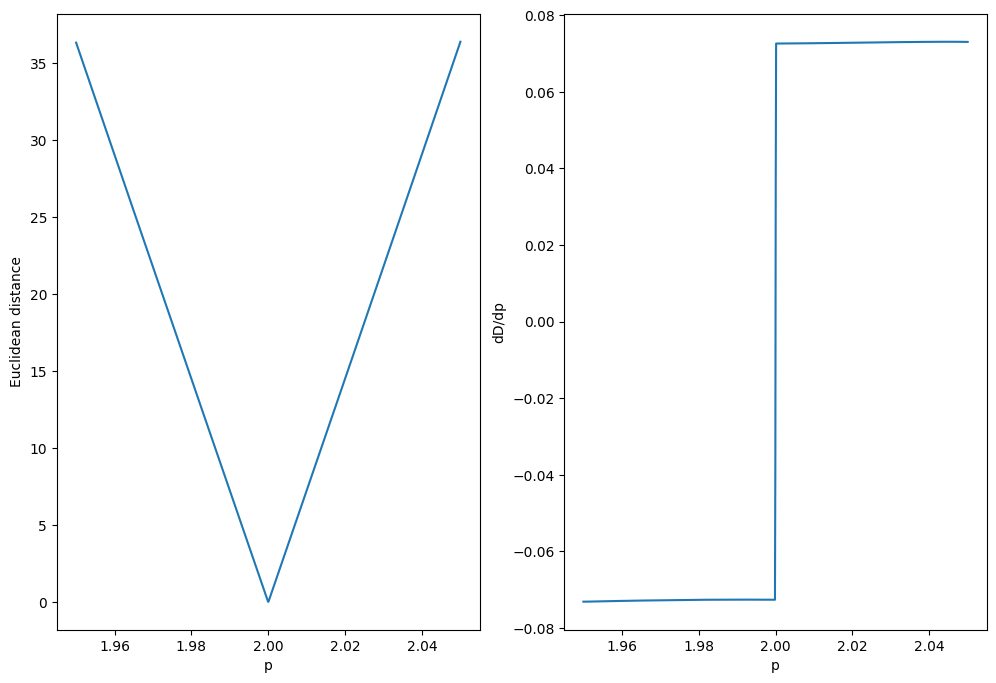

In [65]:
array_p_eval, array_D_eval = plots_sensitivity()

In [66]:
calc_sens_metric(array_p_eval, array_D_eval)

6.4796219905031895

So, results from sensitivity analysis:
b>gamma>n>k>alpha